In [1]:
import glob
import pandas as pd
import numpy as np
import time
from IPython.display import display, HTML

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

In the previous notebook we have extracted relevant features from the GPS trajectories and in this notebook we will try to classify the modality of the trajectories with these features. 

Since the processing can take up a few hours depending on the computational power, the processed data is provided for you. 

It can be downloaded from google drive; https://drive.google.com/open?id=0B22kg5oTwAn-Q0xOVDhRMVNhMDQ
and it is also passed around in memory sticks. 

In [2]:
#The column containing the labels is not exactly in the clean format we want to have it in. 
#Some labels have commas at the begin, end and double commas in the middle, 
#so lets make a function which cleans these labels.
def clean_label(label):
    return label.lstrip(',').rstrip(',').replace(',,', ',')

INPUT_FOLDER = '/home/jordi/Desktop/UNI/TFG/proj7/Data/processed_data/'
headers_metadf = ['trajectory_id', 'start_time', 'end_time', 'v_ave', 'v_med', 'v_max', 'v_std', 'a_ave', 'a_med', 'a_max', 'a_std', 'labels']

#Lets load all of the processed data, containing the features of all trajectories into one single dataframe. 
#The easiest way to do this is to load all of the into a list and concatenate them.
list_df_metadata = []
for file in glob.glob(INPUT_FOLDER + "*.csv"):
    df_metadata = pd.read_csv(file, index_col=0)
    list_df_metadata.append(df_metadata)
print(len(list_df_metadata))
df_metadata = pd.concat(list_df_metadata)

#Remove all rows, which contain NaN values in these columns:
df_labeled = df_metadata.dropna(subset=['v_ave','v_med','v_max', 'a_ave', 'a_med', 'a_max', 'labels'])

#Clean the labels-column
df_labeled.loc[:,'labels'] = df_labeled['labels'].apply(lambda x: clean_label(x))

/home/jordi/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/jordi/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


69


/home/jordi/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Lets analyze the trajectories:

Most of the trajectories are not labeled. 

Of the labeled trajectories around 60% contains a single modality. The other trajectories are multi-modal [walk -> bus -> train, etc] and for now we will not take them into consideration. 

In [3]:
all_labels = df_labeled['labels'].unique()
print(all_labels)
print("Example of trajectory labels:")
for label in all_labels[0:15]:
    print(label)

#We can filter out single modal trajectories by taking the labels which do not contain a comma:
single_modality_labels = [elem for elem in all_labels if ',' not in elem]

df_single_modality = df_labeled[df_labeled['labels'].isin(single_modality_labels)]

print("\nTotal number of trajectories: {}".format(len(df_metadata)))
print("Total number of labeled trajectories: {}".format(len(df_labeled)))
print("Total number of single modality trajectories: {}".format(len(df_single_modality)))

['walk' 'bus' 'subway' 'train' 'car' 'bike' 'run' 'taxi' 'boat' 'airplane'
 'motorcycle']
Example of trajectory labels:
walk
bus
subway
train
car
bike
run
taxi
boat
airplane
motorcycle

Total number of trajectories: 12517364
Total number of labeled trajectories: 5436947
Total number of single modality trajectories: 5436947


Lets split the trajectories containing a single modality, into a 70% training set and a 30% test set.

In [4]:
mask = np.random.rand(len(df_single_modality)) < 0.7
df_train = df_single_modality[mask]
df_test = df_single_modality[~mask]

print(len(df_train))

3806037


The matrices containing the X and Y values of the training set (X_train, Y_train) will be used to train a classifier with. And the matrices X_test and Y_test can be used to test the accuracy of the trained classifier.

Usually a dataset is split randomly into a 70% training set and a 30% test set, but this also depends on the size of the dataset. If the dataset is small, 30% could not be enough for properly testing your trained classifier. 

You could also split it into a 50% / 25% / 25% training set / test set / validation set.
See: https://en.wikipedia.org/wiki/Test_set

In [5]:
#The columns 
X_colnames = ['v_ave','v_med','v_max', 'a_ave', 'a_med', 'a_max']
Y_colnames = ['labels']

X_train = df_train[X_colnames].values
Y_train = np.ravel(df_train[Y_colnames].values)
X_test = df_test[X_colnames].values
Y_test = np.ravel(df_test[Y_colnames].values)

In [6]:
scaler = MinMaxScaler()  # Default behavior is to scale to [0,1]
X_train = scaler.fit_transform(X_train)


Now that we have all of data ready and in the format we want to have it in, lets start with the classification part. 

For classification of the single modal trajectories, we will use three classifiers in the scikit-learn library. 

## 1. Random Forest
http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html


## 2. Logistic Regression
http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

http://ataspinar.com/2016/03/28/regression-logistic-regression-and-maximum-entropy/


## 3. Support Vector Machines.
http://scikit-learn.org/stable/modules/svm.html

https://youtu.be/3liCbRZPrZA


### Also see:

http://www.r2d3.us/visual-intro-to-machine-learning-part-1/

http://ciml.info/


In [6]:
rf_classifier = RandomForestClassifier(n_estimators = 18) #18
#logreg_classifier = LogisticRegression(C=10.0)
#svm_classifier = SVC(kernel='rbf')


In [7]:

#Random Forest
t_start = time.clock()
rf_classifier.fit(X_train, Y_train)
train_score = rf_classifier.score(X_train, Y_train)
t_end = time.clock()
t_diff = t_end - t_start
print("Training time: ", t_diff)



t_start = time.clock()
test_score = rf_classifier.score(X_test, Y_test)
t_end = time.clock()
t_diff2 = t_end - t_start
print("Test time: ", t_diff2)

y_pred_rf= rf_classifier.predict(X_test)
#confusion_matrix_rf = confusion_matrix(Y_test, y_pred_rf) 
print("Score on training / test set: {} / {}".format(train_score, test_score))


'''
#Logistic Regression
t_start = time.clock()
logreg_classifier.fit(X_train, Y_train) #X_train
t_end = time.clock()
t_diff = t_end - t_start

train_score = logreg_classifier.score(X_train, Y_train)
test_score = logreg_classifier.score(X_test, Y_test)
y_pred_logreg = logreg_classifier.predict(X_test)
print("trained Logistic Regression in {:.2f} s.\t Score on training / test set: {} / {}".format(t_diff, train_score, test_score))

#Linear SVM
t_start = time.clock()
svm_classifier.fit(X_train, Y_train)
t_end = time.clock()
t_diff = t_end - t_start
train_score = svm_classifier.score(X_train, Y_train)
test_score = svm_classifier.score(X_test, Y_test)
y_pred_svm = svm_classifier.predict(X_test)
print("trained SVM Classifier in {:.2f} s.\t Score on training / test set: {} / {}".format(t_diff, train_score, test_score))
'''

/home/jordi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/home/jordi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """
/home/jordi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # This is added back by InteractiveShellApp.init_path()


Training time:  36.267171000000005


/home/jordi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  del sys.path[0]


Test time:  4.033710000000006
Score on training / test set: 0.7984462578792587 / 0.7979741371381621


'\n#Logistic Regression\nt_start = time.clock()\nlogreg_classifier.fit(X_train, Y_train) #X_train\nt_end = time.clock()\nt_diff = t_end - t_start\n\ntrain_score = logreg_classifier.score(X_train, Y_train)\ntest_score = logreg_classifier.score(X_test, Y_test)\ny_pred_logreg = logreg_classifier.predict(X_test)\nprint("trained Logistic Regression in {:.2f} s.\t Score on training / test set: {} / {}".format(t_diff, train_score, test_score))\n\n#Linear SVM\nt_start = time.clock()\nsvm_classifier.fit(X_train, Y_train)\nt_end = time.clock()\nt_diff = t_end - t_start\ntrain_score = svm_classifier.score(X_train, Y_train)\ntest_score = svm_classifier.score(X_test, Y_test)\ny_pred_svm = svm_classifier.predict(X_test)\nprint("trained SVM Classifier in {:.2f} s.\t Score on training / test set: {} / {}".format(t_diff, train_score, test_score))\n'

In [15]:
print(y_pred_rf)

['walk' 'walk' 'walk' ... 'walk' 'walk' 'walk']


In [16]:
cm_rf = confusion_matrix(Y_test, y_pred_rf)
#cm_logreg = confusion_matrix(Y_test, y_pred_logreg)
#cm_svm = confusion_matrix(Y_test, y_pred_svm)


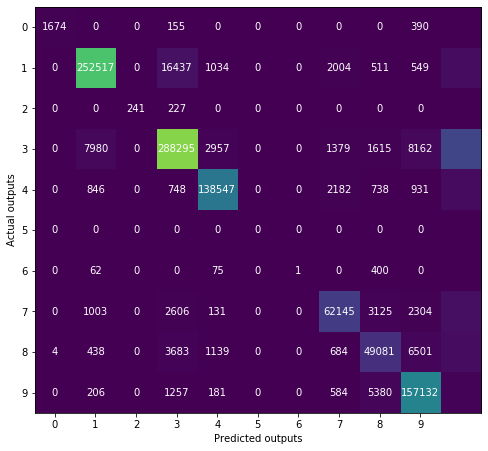

In [20]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm_rf)
ax.grid(False)
ax.set_xlabel('Predicted outputs', color='black')
ax.set_ylabel('Actual outputs', color='black')
ax.xaxis.set(ticks=range(10))
ax.yaxis.set(ticks=range(10))
ax.set_ylim(9.5, -0.5)
for i in range(10):
    for j in range(10):
        ax.text(j, i, cm_rf[i, j], ha='center', va='center', color='white')
plt.show()

## Improving the accuracy of RF classifier
The most accurate classifier is the Random Forest classifier, with an accuracy of 78 % on the test set. 
Although this is already quiet high, lets see how we can improve it even more. 

To be able to do this, first we need to understand what this average accuracy of 78% consists of.

In the cell below:

- print the number of entries of each modality in the dataset.
- print the f1-score per class within the test set. 

hint: the metrics module of the scikit-learn library contains a lot of methods which can be used to evaluate the performance of your classifier:
http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics

In [14]:
from collections import Counter
print(Counter(df_single_modality['labels'].values))
from sklearn.metrics import classification_report
print(classification_report(Y_test, y_pred_rf))

Counter({'walk': 15848, 'subway': 3504, 'car': 2722, 'bus': 1897, 'bike': 1435, 'taxi': 811, 'train': 85})
              precision    recall  f1-score   support

        bike       0.00      0.00      0.00       432
         bus       0.00      0.00      0.00       562
         car       0.11      0.91      0.19       845
      subway       0.00      0.00      0.00      1045
        taxi       0.00      0.00      0.00       265
       train       0.00      0.00      0.00        26
        walk       1.00      0.01      0.02      4734

    accuracy                           0.10      7909
   macro avg       0.16      0.13      0.03      7909
weighted avg       0.61      0.10      0.03      7909



/home/jordi/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
from collections import Counter
print(Counter(df_single_modality['labels'].values))
from sklearn.metrics import classification_report
print(classification_report(Y_test, y_pred_logreg))

Counter({'walk': 15848, 'subway': 3504, 'car': 2722, 'bus': 1897, 'bike': 1435, 'taxi': 811, 'train': 85})
              precision    recall  f1-score   support

        bike       0.21      0.28      0.24       432
         bus       0.00      0.00      0.00       562
         car       0.21      0.24      0.22       845
      subway       0.00      0.00      0.00      1045
        taxi       0.00      0.00      0.00       265
       train       0.00      0.00      0.00        26
        walk       0.68      0.91      0.78      4734

    accuracy                           0.59      7909
   macro avg       0.16      0.20      0.18      7909
weighted avg       0.44      0.59      0.50      7909



In [17]:
from collections import Counter
print(Counter(df_single_modality['labels'].values))
from sklearn.metrics import classification_report
print(classification_report(Y_test, y_pred_svm))

Counter({'walk': 15848, 'subway': 3504, 'car': 2722, 'bus': 1897, 'bike': 1435, 'taxi': 811, 'train': 85})
              precision    recall  f1-score   support

        bike       0.00      0.00      0.00       432
         bus       0.00      0.00      0.00       562
         car       0.00      0.00      0.00       845
      subway       0.00      0.00      0.00      1045
        taxi       0.00      0.00      0.00       265
       train       0.00      0.00      0.00        26
        walk       0.60      1.00      0.75      4734

    accuracy                           0.60      7909
   macro avg       0.09      0.14      0.11      7909
weighted avg       0.36      0.60      0.45      7909



If there are not enough entries of a specific class in the dataset, the classifier will difficulties of finding a general rule which can correctly model it. This will lower the overall accuracy of the classifier, so lets remove all of the modalities which have less than 10 entries in 'df_single_modality'. 

In [23]:
#remove all of the labels which have less than 10 entries.
print(single_modality_labels)
#single_modality_labels.remove('run')
#single_modality_labels.remove('boat')
#single_modality_labels.remove('airplane')
#single_modality_labels.remove('motorcycle')
print(single_modality_labels)

['walk', 'bus', 'subway', 'train', 'car', 'bike', 'taxi', 'boat', 'airplane']
['walk', 'bus', 'subway', 'train', 'car', 'bike', 'taxi', 'boat', 'airplane']


You might also have seen that there are entries which are labeled as a different modality, although the behaviour will be approximately the same (for example car vs taxi). Incorrectly classifying these entries will also lower the accuracy of the classifier. Which of the existing labels in df_single_modality can be combined into one label?

In [24]:
#combine classes which will have the same driving behaviour into a new single label.
df_single_modality = df_labeled[df_labeled['labels'].isin(single_modality_labels)]
to_general_label = {'airplane': 'airplane', 'bike': 'bike', 'subway': 'subway', 'train': 'train', 'run': 'run', 'walk': 'walk', 'boat': 'boat', 'bus': 'vehicle', 'car': 'vehicle', 'taxi': 'vehicle'}
df_single_modality['labels'] = df_single_modality['labels'].apply(lambda x: to_general_label[x])


/home/jordi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


With the new and improved df_single_modality:
- generate training and test sets
- train the three classifiers and determine if the accuracy has improved 

In [25]:
mask = np.random.rand(len(df_single_modality)) < 0.7
df_train = df_single_modality[mask]
df_test = df_single_modality[~mask]
X_train = df_train[X_colnames].values
Y_train = np.ravel(df_train[Y_colnames].values)
X_test = df_test[X_colnames].values
Y_test = np.ravel(df_test[Y_colnames].values)

In [26]:
rf_classifier = RandomForestClassifier(n_estimators = 100)
logreg_classifier = LogisticRegression()
svm_classifier = SVC(kernel='rbf')


#Random Forest
t_start = time.clock()
rf_classifier.fit(X_train, Y_train)
t_end = time.clock()
t_diff = t_end - t_start

train_score = rf_classifier.score(X_train, Y_train)
test_score = rf_classifier.score(X_test, Y_test)
y_pred_rf= rf_classifier.predict(X_test)
print("trained Random Forest in {:.2f} s.\t Score on training / test set: {} / {}".format(t_diff, train_score, test_score))

#Logistic Regression
t_start = time.clock()
logreg_classifier.fit(X_train, Y_train)
t_end = time.clock()
t_diff = t_end - t_start

train_score = logreg_classifier.score(X_train, Y_train)
test_score = logreg_classifier.score(X_test, Y_test)
y_pred_logreg = logreg_classifier.predict(X_test)
print("trained Logistic Regression in {:.2f} s.\t Score on training / test set: {} / {}".format(t_diff, train_score, test_score))
'''
#Linear SVM
t_start = time.clock()
svm_classifier.fit(X_train, Y_train)
t_end = time.clock()
t_diff = t_end - t_start

train_score = svm_classifier.score(X_train, Y_train)
test_score = svm_classifier.score(X_test, Y_test)
y_pred_svm = svm_classifier.predict(X_test)
print("trained SVM Classifier in {:.2f} s.\t Score on training / test set: {} / {}".format(t_diff, train_score, test_score))
'''

/home/jordi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  import sys
/home/jordi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if __name__ == '__main__':


trained Random Forest in 128.53 s.	 Score on training / test set: 0.8061389753557767 / 0.8054435130946875


/home/jordi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/home/jordi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/jordi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


trained Logistic Regression in 274.10 s.	 Score on training / test set: 0.41620756536594605 / 0.41588339312684763


'\n#Linear SVM\nt_start = time.clock()\nsvm_classifier.fit(X_train, Y_train)\nt_end = time.clock()\nt_diff = t_end - t_start\n\ntrain_score = svm_classifier.score(X_train, Y_train)\ntest_score = svm_classifier.score(X_test, Y_test)\ny_pred_svm = svm_classifier.predict(X_test)\nprint("trained SVM Classifier in {:.2f} s.\t Score on training / test set: {} / {}".format(t_diff, train_score, test_score))\n'

In [27]:
from collections import Counter
print(Counter(df_single_modality['labels'].values))
from sklearn.metrics import classification_report
print(classification_report(Y_test, y_pred_rf))

Counter({'vehicle': 2035686, 'walk': 1590053, 'bike': 948260, 'train': 561031, 'subway': 286845, 'airplane': 9193, 'boat': 3566})
              precision    recall  f1-score   support

    airplane       1.00      0.62      0.76      2696
        bike       0.93      0.88      0.91    283546
        boat       1.00      0.21      0.35      1092
      subway       0.81      0.72      0.76     85964
       train       0.84      0.93      0.88    168130
     vehicle       0.79      0.80      0.80    609730
        walk       0.74      0.74      0.74    476945

    accuracy                           0.81   1628103
   macro avg       0.87      0.70      0.74   1628103
weighted avg       0.81      0.81      0.81   1628103



In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

del df_single_modality['trajectory_id']
del df_single_modality['start_time']
del df_single_modality['end_time']
display(df_single_modality.head())


KeyError: 'start_time'

In [29]:
le = preprocessing.LabelEncoder()
col_values_unique = list(df_single_modality['labels'].unique())
le_fitted = le.fit(col_values_unique)

col_values = list(df_single_modality['labels'].values)
le.classes_
col_values_transformed = le.transform(col_values)
df_single_modality['labels'] = col_values_transformed
display(df_single_modality.head())

/home/jordi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,lat,long,altitude,datetime,timedelta,distance,velocity,acceleration,subfolder,labels,v_ave,v_med,v_max,a_ave,a_med,a_max
0,39.908709,116.366118,-60.0,2011-03-19 09:11:34,0 days 00:00:01.000000000,6.331184,6.331184,-3.555362,67,6,2.150206,1.357167,11.051963,-0.127628,-0.012421,3.342413
1,39.908766,116.366116,43.0,2011-03-19 09:11:35,0 days 00:00:01.000000000,2.775822,2.775822,-2.214171,67,6,2.150206,1.357167,11.051963,-0.127628,-0.012421,3.342413
2,39.908791,116.366116,93.0,2011-03-19 09:11:36,0 days 00:00:02.000000000,1.123302,0.561651,0.063073,67,6,2.150206,1.357167,11.051963,-0.127628,-0.012421,3.342413
3,39.908800,116.366122,152.0,2011-03-19 09:11:38,0 days 00:00:03.000000000,2.063391,0.687797,0.057019,67,6,2.150206,1.357167,11.051963,-0.127628,-0.012421,3.342413
4,39.908818,116.366116,181.0,2011-03-19 09:11:41,0 days 00:00:03.000000000,2.576559,0.858853,0.184155,67,6,2.150206,1.357167,11.051963,-0.127628,-0.012421,3.342413


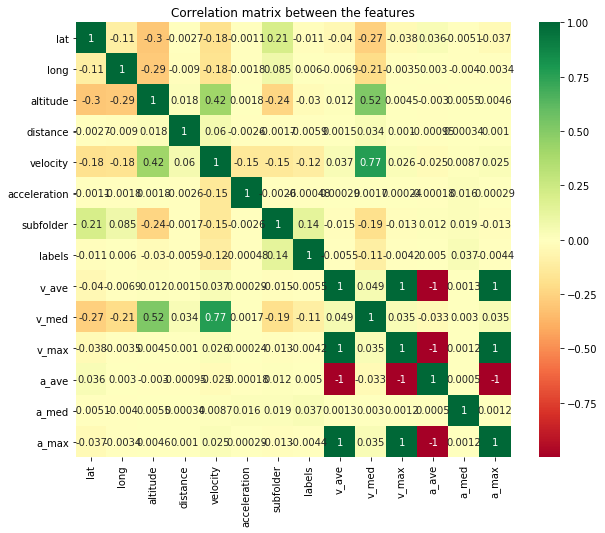

In [30]:
correlation_matrix = df_single_modality.corr()
plt.figure(figsize=(10,8))
ax = sns.heatmap(correlation_matrix, vmax=1, square=True,annot=True,cmap='RdYlGn')
plt.title('Correlation matrix between the features')
plt.show()

X = df_single_modality[X_colnames].values

[9.99810740e-01 1.88622743e-04 6.02793442e-07 3.26601799e-08
 1.99433355e-09 3.77160819e-11]
[-0.0375139   0.2538233   0.22323781 -0.12863579 -0.17027561 -0.07387178]


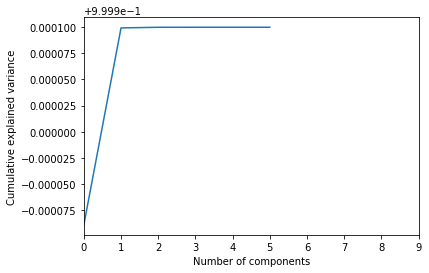

In [31]:
X_std = StandardScaler().fit_transform(X)

pca = PCA().fit(X)
var_ratio = pca.explained_variance_ratio_
components = pca.components_
print(var_ratio)
print(np.mean(pca.components_,axis=0))
plt.plot(np.cumsum(var_ratio))
plt.xlim(0,9,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()